# Calibration on CNNs

In [1]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina' 

import numpy as np
import torch
from torch import nn
from torch import optim
import matplotlib.pyplot as plt

#### Data Preparation


In [2]:
from torchvision import datasets, transforms, utils, models

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

# Load the full CIFAR10 dataset
trainset = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
testset = datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)


# function to filter out classes 2 and 3
def filter_classes(dataset):
    class_indices = []
    for i in range(len(dataset)):
        _, class_idx = dataset[i]
        if class_idx == 2 or class_idx == 3:
            class_indices.append(i)
    return class_indices

# Get the indices of classes 2 and 3
filtered_indices = filter_classes(trainset)

# Create a subset of the dataset with only classes 2 and 3
filtered_trainset = torch.utils.data.Subset(trainset, filtered_indices)

trainloader = torch.utils.data.DataLoader(filtered_trainset, batch_size=64, shuffle=True, num_workers=2)

filtered_indices = filter_classes(testset)
filtered_testset = torch.utils.data.Subset(testset, filtered_indices)
testloader = torch.utils.data.DataLoader(filtered_testset, batch_size=64, shuffle=True, num_workers=2)

Files already downloaded and verified
Files already downloaded and verified


In [3]:
images, labels = next(iter(trainloader))

print(images[1].shape)

torch.Size([3, 32, 32])


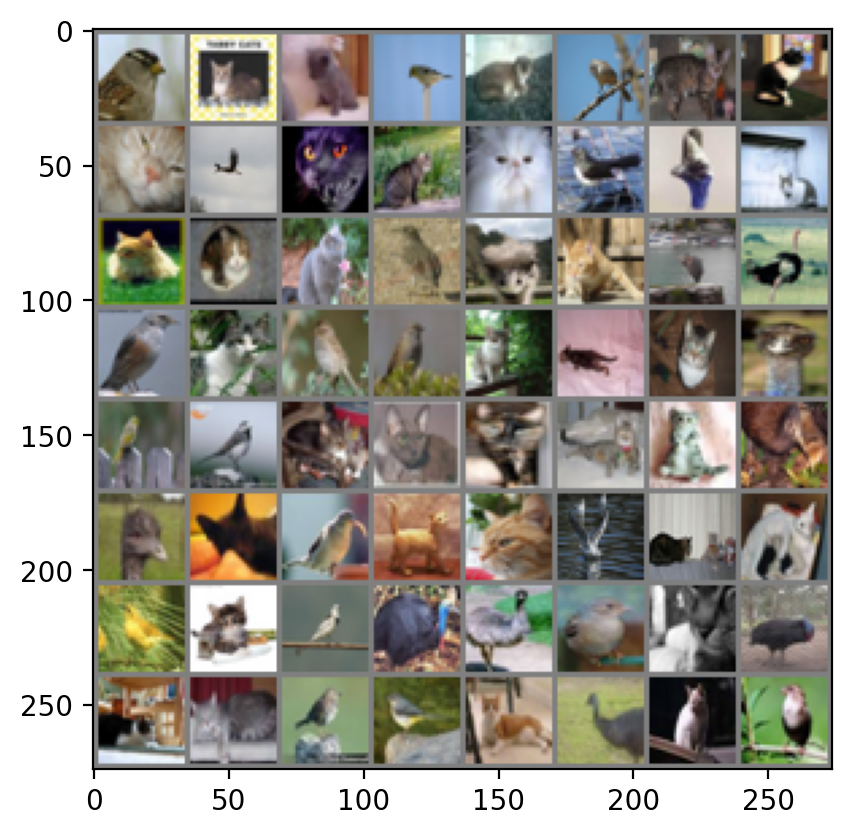

In [4]:
def imshow(img):
    img = img / 2 + 0.5   
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

imshow(utils.make_grid(images))

Create validation set using 20% of train images

In [5]:
from torch.utils.data import DataLoader, random_split

# Calculate the size of the validation set (20% of the original dataset)
dataset_size = len(trainloader.dataset)
valid_size = int(0.2 * dataset_size)
train_size = dataset_size - valid_size

# Split the dataset into training and validation sets
train_dataset, valid_dataset = random_split(trainloader.dataset, [train_size, valid_size])

# Create DataLoader for training and validation sets
trainloader = DataLoader(train_dataset, batch_size=64, shuffle=True)
validloader = DataLoader(valid_dataset, batch_size=64, shuffle=False)

### LENET 5

In [6]:
class Lenet5(nn.Module):
    def __init__(self,dimx,nlabels): 
        super().__init__()

        # convolutional layer (sees 32x32x3 image tensor)
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=6, 
                               kernel_size=5, stride=1, padding=0)
        
        # convolutional layer (sees 12x12x6 tensor)
        self.conv2 = nn.Conv2d(6, 16, 5, padding=0)
        
        # Max pool layer
        self.pool = nn.MaxPool2d(2, 2)

        # Linear layers
        self.linear1 = nn.Linear(400,120)
        
        self.linear2 = nn.Linear(120,84)
        
        self.linear3 = nn.Linear(84,10)
    
        self.relu = nn.ReLU()
        
        self.logsoftmax = nn.LogSoftmax(dim=1) 
        
        # Spatial dimension of the Tensor at the output of the 2nd CNN
        self.final_dim = int(((dimx-4)/2-4)/2)  #((32-4)/2-4)/2=5
        
    def forward(self, x):
        x = self.conv1(x) 
        x = self.relu(x) 
        x = self.pool(x)
        x = self.conv2(x)
        x = self.relu(x)
        x = self.pool(x)
        # Flatten the tensor 
        x = x.view(-1, 16 * self.final_dim**2)
        x = self.linear1(x)
        x = self.relu(x)
        x = self.linear2(x)
        x = self.relu(x)
        x = self.linear3(x) # output logits not probs, for later on temperature scaling
        return x


In [7]:
class Lenet5_extended(Lenet5):
    
    def __init__(self,dimx,nlabels,epochs=100,lr=0.001):
        
        super().__init__(dimx,nlabels)  
        
        self.lr = lr 
        
        self.optim = optim.Adam(self.parameters(), self.lr)
        
        self.epochs = epochs
        
        self.criterion = nn.NLLLoss()              
        
        self.loss_during_training = [] 
        
        self.valid_loss_during_training = []

        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

        self.to(self.device)
    
        
    def trainloop(self,trainloader,validloader):
        
        for e in range(int(self.epochs)):
            running_loss = 0.
            
            for images, labels in trainloader:              
        
                images, labels = images.to(self.device), labels.to(self.device)

                self.optim.zero_grad() 
            
                logits = self.forward(images)

                out = self.logsoftmax(logits)
                loss = self.criterion(out,labels)

                running_loss += loss.item()
                loss.backward()
                self.optim.step()
                
                
            self.loss_during_training.append(running_loss/len(trainloader))
            
            with torch.no_grad():            
                
                running_loss = 0.
                
                for images,labels in validloader:
                    
                    images, labels = images.to(self.device), labels.to(self.device)

                    logits = self.forward(images)

                    out = self.logsoftmax(logits)
                    loss = self.criterion(out,labels)

                    running_loss += loss.item()   
                    
                self.valid_loss_during_training.append(running_loss/len(validloader))    
                    

            if(e % 1 == 0): 

                print("Epoch %d. Training loss: %f, Validation loss: %f" 
                      %(e,self.loss_during_training[-1],self.valid_loss_during_training[-1]))

    def eval_performance(self,dataloader):
        accuracy = 0
        with torch.no_grad():

            for images,labels in dataloader:

                images, labels = images.to(self.device), labels.to(self.device)

                logits = self.forward(images)
                probs = self.logsoftmax(logits)

                top_p, top_class = probs.topk(1, dim=1)
                equals = (top_class == labels.view(images.shape[0], 1))
                accuracy += torch.mean(equals.type(torch.FloatTensor))
    
            return accuracy/len(dataloader)      

In [8]:
my_CNN = Lenet5_extended(dimx=32,nlabels=2,epochs=7,lr=1e-3)

my_CNN.trainloop(trainloader,validloader)

Epoch 0. Training loss: 0.766852, Validation loss: 0.615287
Epoch 1. Training loss: 0.570065, Validation loss: 0.521790
Epoch 2. Training loss: 0.525738, Validation loss: 0.513299
Epoch 3. Training loss: 0.499915, Validation loss: 0.502161
Epoch 4. Training loss: 0.486500, Validation loss: 0.501867
Epoch 5. Training loss: 0.473214, Validation loss: 0.484706
Epoch 6. Training loss: 0.453294, Validation loss: 0.522126


tensor(0.7688)
tensor(0.7593)


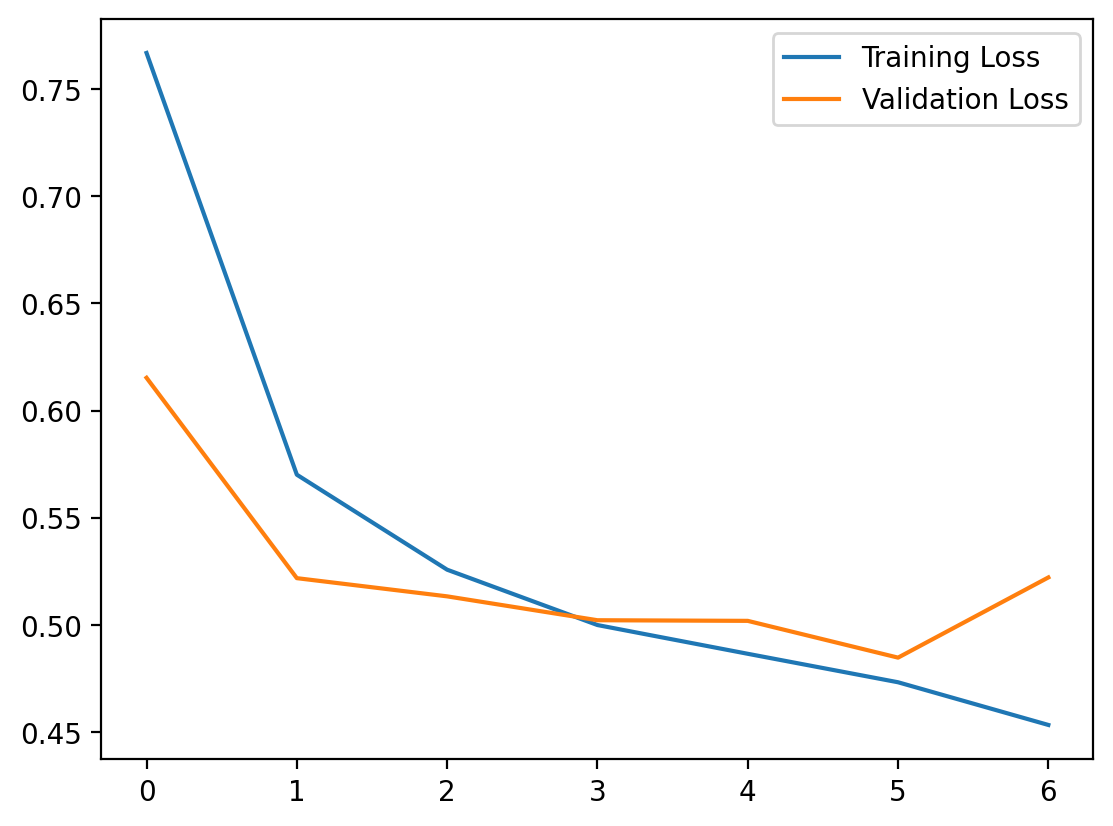

In [9]:
plt.plot(my_CNN.loss_during_training,label='Training Loss')
plt.plot(my_CNN.valid_loss_during_training,label='Validation Loss')
plt.legend()

print(my_CNN.eval_performance(trainloader))
print(my_CNN.eval_performance(validloader))

### Reliability diagram and ECE of model

In [25]:
class Lenet5_extended(Lenet5):
    
    def __init__(self,dimx,nlabels,epochs=100,lr=0.001):
        
        super().__init__(dimx,nlabels)  
        
        self.lr = lr 
        
        self.optim = optim.Adam(self.parameters(), self.lr)
        
        self.epochs = epochs
        
        self.criterion = nn.NLLLoss()             
        
        self.loss_during_training = [] 
        
        self.valid_loss_during_training = []

        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

        self.to(self.device)
        
    def trainloop(self,trainloader,validloader):
        
        for e in range(int(self.epochs)):
            running_loss = 0.
            
            for images, labels in trainloader:              
        
                images, labels = images.to(self.device), labels.to(self.device)

                self.optim.zero_grad() 
            
                logits = self.forward(images)
                out = self.logsoftmax(logits)

                loss = self.criterion(out,labels)

                running_loss += loss.item()
                loss.backward()
                self.optim.step()
                
                
            self.loss_during_training.append(running_loss/len(trainloader))
            with torch.no_grad():            
                
                running_loss = 0.
                
                for images,labels in validloader:
                    
                    images, labels = images.to(self.device), labels.to(self.device)

                    logits = self.forward(images)
                    out = self.logsoftmax(logits)

                    loss = self.criterion(out,labels)

                    running_loss += loss.item()   
                    
                self.valid_loss_during_training.append(running_loss/len(validloader))    
                    

            if(e % 1 == 0): 

                print("Epoch %d. Training loss: %f, Validation loss: %f" 
                      %(e,self.loss_during_training[-1],self.valid_loss_during_training[-1]))


    def eval_performance(self, dataloader):
        self.eval() 
        accuracy = 0
        confidence = []  # Confidence scores
        true_labels = []  # True labels

        with torch.no_grad(): 
            for images, labels in dataloader:
                images, labels = images.to(self.device), labels.to(self.device)
                logits = self.forward(images)
                probs = self.logsoftmax(logits)
                
                # Calculate accuracy
                _, top_class = torch.max(probs, dim=1)
                equals = top_class == labels
                accuracy += torch.mean(equals.type(torch.FloatTensor)).item()

                # Save confidence scores and true labels
                confidence.extend(torch.exp(probs)[:,2].cpu().numpy())  # class '2' is for cats
                true_labels.extend(labels.cpu().numpy())

        accuracy /= len(dataloader)
        return accuracy, confidence, true_labels

In [26]:
my_CNN = Lenet5_extended(dimx=32,nlabels=2,epochs=5,lr=1e-3)

my_CNN.trainloop(trainloader,validloader)

Epoch 0. Training loss: 0.802811, Validation loss: 0.645727
Epoch 1. Training loss: 0.590990, Validation loss: 0.558823
Epoch 2. Training loss: 0.531319, Validation loss: 0.522841
Epoch 3. Training loss: 0.497515, Validation loss: 0.496059
Epoch 4. Training loss: 0.476114, Validation loss: 0.477236


In [27]:
from sklearn.calibration import calibration_curve

def reliability_diagram(confidence, true_labels, n_bins=10):
    prob_true, prob_pred = calibration_curve(true_labels, confidence, n_bins=n_bins, strategy='uniform')
    return prob_true, prob_pred

def expected_calibration_error(prob_true, prob_pred):
    ece = np.sum(np.abs(prob_true - prob_pred)) / len(prob_true)  # Weighted average
    return ece

accuracy, confidence, true_labels = my_CNN.eval_performance(testloader)

true_labels_binary = [1 if label == 2 else 0 for label in true_labels]

# Ahora puedes llamar a reliability_diagram con las etiquetas binarias
prob_true, prob_pred = reliability_diagram(confidence, true_labels_binary)
ece = expected_calibration_error(prob_true, prob_pred)

print(f"Accuracy: {accuracy:.4f}")
print(f"Expected Calibration Error (ECE): {ece:.4f}")

Accuracy: 0.7778
Expected Calibration Error (ECE): 0.0236


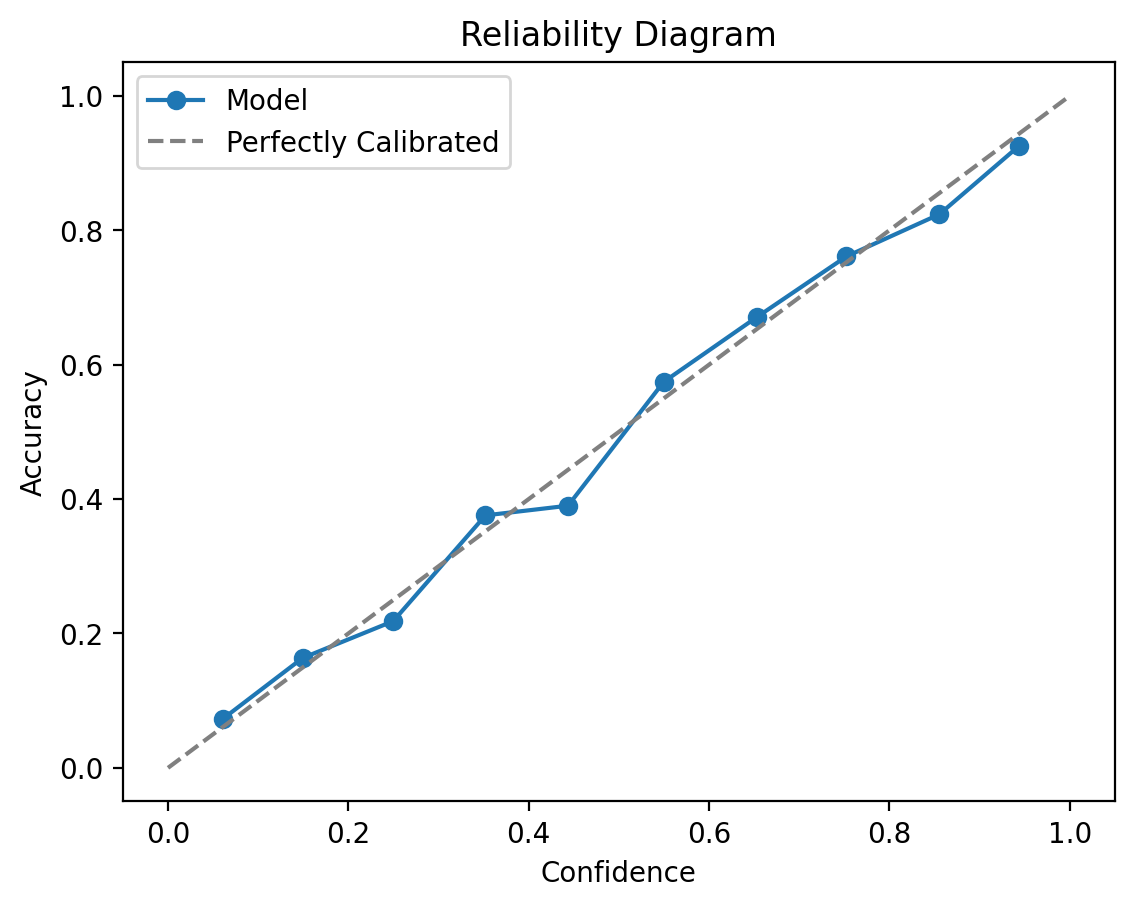

In [28]:
plt.plot(prob_pred, prob_true, marker='o', label='Model')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray', label='Perfectly Calibrated')
x = np.linspace(0, 1, len(prob_pred))

# plt.fill_between(x, prob_true, x, color='blue', alpha=0.2)

plt.xlabel('Confidence')
plt.ylabel('Accuracy')
plt.title('Reliability Diagram')
plt.legend()
plt.show()

## Temperature Scaling

In [31]:
class Lenet5_extended(Lenet5):
    
    def __init__(self,dimx,nlabels,epochs=100,lr=0.001, a=1):
        
        super().__init__(dimx,nlabels)  
        
        self.lr = lr 
        
        self.optim = optim.Adam(self.parameters(), self.lr)
        
        self.epochs = epochs
        
        self.criterion = nn.NLLLoss()           

        self.a = a  # temperature scaling paramenter a
        
        self.loss_during_training = [] 
        
        self.valid_loss_during_training = []

        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

        self.to(self.device)
        
    def trainloop(self,trainloader,validloader):
        
        
        for e in range(int(self.epochs)):
            
            running_loss = 0.
            
            for images, labels in trainloader:              
        
                images, labels = images.to(self.device), labels.to(self.device)

                self.optim.zero_grad() 
            
                logits = self.forward(images)
                out = self.logsoftmax(logits)

                loss = self.criterion(out,labels)

                running_loss += loss.item()

                loss.backward()
                
                self.optim.step()
                
                
            self.loss_during_training.append(running_loss/len(trainloader))
            
            with torch.no_grad():            
                
                running_loss = 0.
                
                for images,labels in validloader:
                    
                    images, labels = images.to(self.device), labels.to(self.device)

                    logits = self.forward(images)
                    out = self.logsoftmax(logits)

                    loss = self.criterion(out,labels)

                    running_loss += loss.item()   
                    
                self.valid_loss_during_training.append(running_loss/len(validloader))    
                    

            if(e % 1 == 0): 

                print("Epoch %d. Training loss: %f, Validation loss: %f" 
                      %(e,self.loss_during_training[-1],self.valid_loss_during_training[-1]))

    def eval_performance(self, dataloader, a = 1):
        self.eval() 
        accuracy = 0
        confidence = []  # Confidence scores
        true_labels = []  # True labels

        with torch.no_grad(): 
            for images, labels in dataloader:
                images, labels = images.to(self.device), labels.to(self.device)
                logits = self.forward(images)
                
                # Platt's scaling
                scaled_logits = logits * a 
                probs = self.logsoftmax(scaled_logits)
                
                # Calculate accuracy
                _, top_class = torch.max(probs, dim=1)
                equals = top_class == labels
                accuracy += torch.mean(equals.type(torch.FloatTensor)).item()

                # Save confidence scores and true labels
                confidence.extend(torch.exp(probs)[:,2].cpu().numpy())  # class '2' is for cats
                true_labels.extend(labels.cpu().numpy())

        accuracy /= len(dataloader)
        return accuracy, confidence, true_labels

In [37]:
temperature_CNN = Lenet5_extended(dimx=32,nlabels=2,epochs=5,lr=1e-3)
temperature_CNN.trainloop(trainloader,validloader)

Epoch 0. Training loss: 0.783545, Validation loss: 0.649736
Epoch 1. Training loss: 0.604994, Validation loss: 0.601182
Epoch 2. Training loss: 0.530723, Validation loss: 0.521988
Epoch 3. Training loss: 0.501068, Validation loss: 0.513025
Epoch 4. Training loss: 0.495084, Validation loss: 0.499235


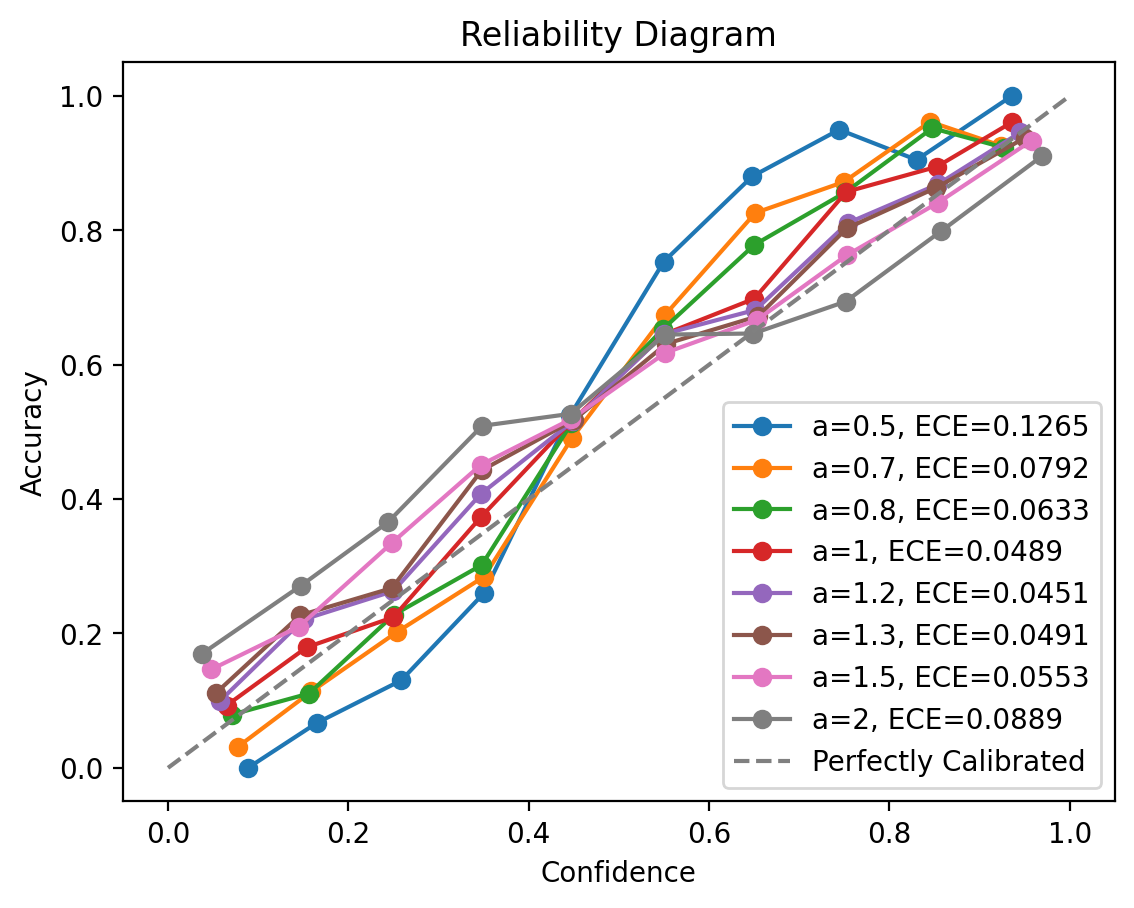

In [39]:
from sklearn.calibration import calibration_curve

def reliability_diagram(confidence, true_labels, n_bins=10):
    prob_true, prob_pred = calibration_curve(true_labels, confidence, n_bins=n_bins, strategy='uniform')
    return prob_true, prob_pred

def expected_calibration_error(prob_true, prob_pred):
    ece = np.sum(np.abs(prob_true - prob_pred)) / len(prob_true)  # Weighted average
    return ece

temperature_parameters = [0.5, 0.7, 0.8, 1, 1.2, 1.3, 1.5, 2]

for a in temperature_parameters:

    accuracy, confidence, true_labels = temperature_CNN.eval_performance(testloader, a)

    true_labels_binary = [1 if label == 2 else 0 for label in true_labels]

    prob_true, prob_pred = reliability_diagram(confidence, true_labels_binary)
    ece = expected_calibration_error(prob_true, prob_pred)

    plt.plot(prob_pred, prob_true, marker='o', label=f'a={a}, ECE={ece:.4f}')


plt.plot([0, 1], [0, 1], linestyle='--', color='gray', label='Perfectly Calibrated')
x = np.linspace(0, 1, len(prob_pred))

# plt.fill_between(x, prob_true, x, color='blue', alpha=0.2)

plt.xlabel('Confidence')
plt.ylabel('Accuracy')
plt.title('Reliability Diagram')
plt.legend()
plt.show()

### Showcasing big differences

0.7626953125
0.76123046875


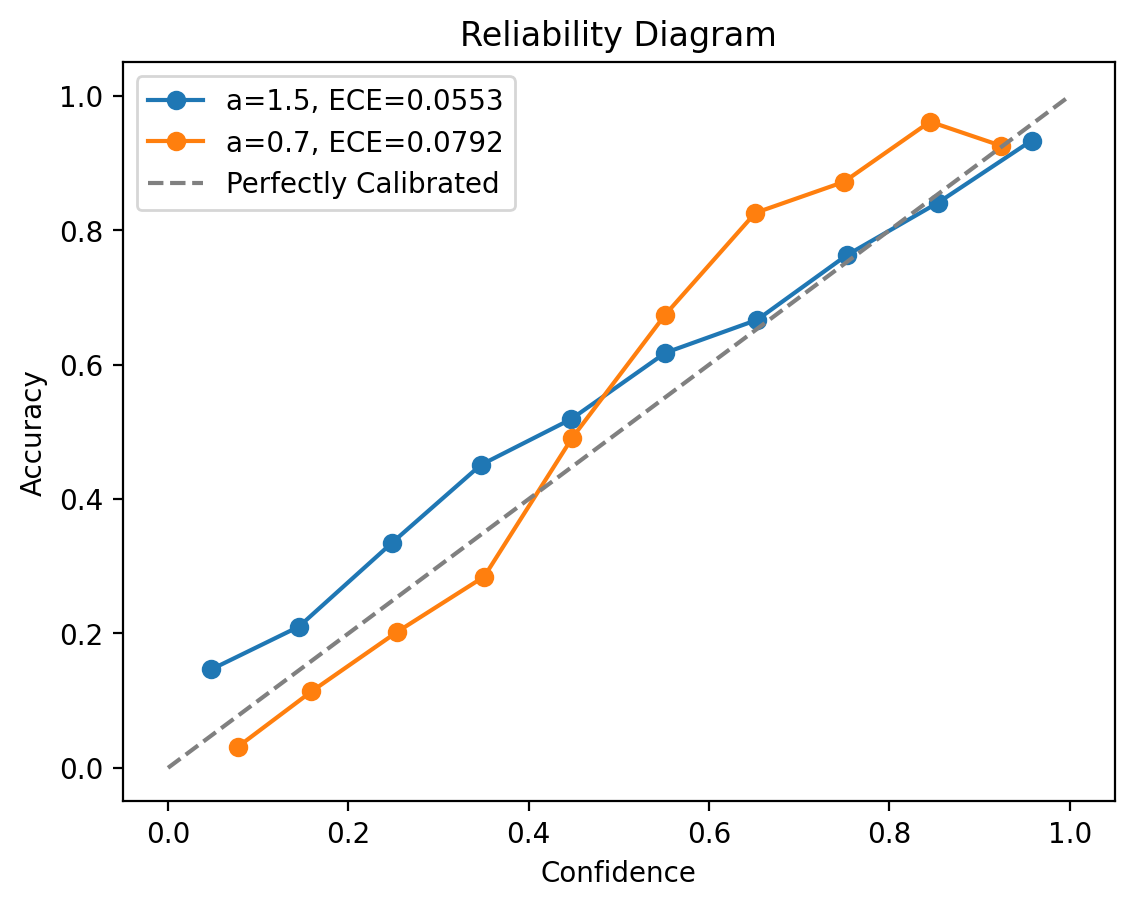

In [40]:
temperature_parameters = [1.5, 0.7]

for a in temperature_parameters:

    accuracy, confidence, true_labels = temperature_CNN.eval_performance(testloader, a)

    true_labels_binary = [1 if label == 2 else 0 for label in true_labels]

    prob_true, prob_pred = reliability_diagram(confidence, true_labels_binary)
    ece = expected_calibration_error(prob_true, prob_pred)
    plt.plot(prob_pred, prob_true, marker='o', label=f'a={a}, ECE={ece:.4f}')


plt.plot([0, 1], [0, 1], linestyle='--', color='gray', label='Perfectly Calibrated')
x = np.linspace(0, 1, len(prob_pred))

# plt.fill_between(x, prob_true, x, color='blue', alpha=0.2)

plt.xlabel('Confidence')
plt.ylabel('Accuracy')
plt.title('Reliability Diagram')
plt.legend()
plt.show()

* Small Values of a (a < 1):

The calibrated probabilities become more confident, but this results in overconfidence.
The reliability diagram shows underestimation of uncertainty.

* Large Values of a (a > 1):

Larger values of a yield smoother probability curves.
The calibrated probabilities become more conservative, reducing overconfidence.
The reliability diagram shows overestimation of uncertainty.

## Much Bigger Model

VGG model

In [94]:
from torchvision import models
model = models.vgg16(pretrained=True)
model

c:\Users\casan\AppData\Local\Programs\Python\Python311\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\casan\AppData\Local\Programs\Python\Python311\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

Creating classifier layer for our task, returning logits

In [95]:
class MLP(nn.Module):
    def __init__(self, nlabels=10): 
        
        super().__init__()

        self.output1 = nn.Linear(25088,1024)

        self.output2 = nn.Linear(1024,500) 
    
        self.output3 = nn.Linear(500,nlabels) 
    
        self.relu = nn.ReLU()
        
        self.logsoftmax = nn.LogSoftmax(dim=1)                                                             
        
    def forward(self, x):

        x = self.output1(x)
        x = self.relu(x)
        x = self.output2(x)
        x = self.relu(x)
        x = self.output3(x)
        return x

In [96]:
for param in model.parameters():
    param.requires_grad = False

classifier = MLP()
    
model.classifier = classifier
model

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [120]:
class Tran_Eval():
    def __init__(self,model,maxiter=500,lr=0.001):
        
        self.model = model
        
        self.lr = lr 
        
        self.optim = optim.Adam(self.model.classifier.parameters(), self.lr)
        
        self.max_iter = maxiter
        
        self.criterion = nn.NLLLoss()             
        
        self.logsoftmax = nn.LogSoftmax(dim=1) 
        
        self.loss_during_training = [] 
        
        self.valid_loss_during_training = []
        
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

        self.model.to(self.device)
        
    def trainloop(self,trainloader):
        
        it_images = iter(trainloader)
        
        running_loss = 0.
        
        self.model.train()
        
        for e in range(int(self.max_iter)):

          
            images,labels = next(it_images)

            images, labels = images.to(self.device), labels.to(self.device)  
        
            self.optim.zero_grad() 

            logits = self.model.forward(images) 
            out = self.logsoftmax(logits)
            
            loss = self.criterion(out,labels)

            running_loss = loss.item()
            loss.backward()
            self.optim.step()

            self.loss_during_training.append(running_loss)
            
            print('Batch %d of %d finished. Loss %f' %(e,self.max_iter,running_loss))            
    

    def eval_performance(self, dataloader, a=1):
        accuracy = 0
        confidence = []  # Confidence scores
        true_labels = []  # True labels

        with torch.no_grad():
            self.model.eval()

            for images, labels in dataloader:

                #images,labels = next(it_images)
                images, labels = images.to(self.device), labels.to(self.device)
                logits = self.model.forward(images)
                
                # Platt's scaling
                scaled_logits = logits * a 
                probs = self.logsoftmax(scaled_logits)
                
                # Calculate accuracy
                _, top_class = torch.max(probs, dim=1)
                equals = top_class == labels
                accuracy += torch.mean(equals.type(torch.FloatTensor)).item()

                # Save confidence scores and true labels
                confidence.extend(torch.exp(probs)[:,2].cpu().numpy())  # class '2' is for cats
                true_labels.extend(labels.cpu().numpy())

        accuracy /= len(dataloader)
        return accuracy, confidence, true_labels

In [121]:
model_with_train = Tran_Eval(model,maxiter=50)

Batch 0 of 50 finished. Loss 0.156000
Batch 1 of 50 finished. Loss 0.115584
Batch 2 of 50 finished. Loss 0.203949
Batch 3 of 50 finished. Loss 0.182932
Batch 4 of 50 finished. Loss 0.098646
Batch 5 of 50 finished. Loss 0.068309
Batch 6 of 50 finished. Loss 0.241670
Batch 7 of 50 finished. Loss 0.321502
Batch 8 of 50 finished. Loss 0.210373
Batch 9 of 50 finished. Loss 0.293839
Batch 10 of 50 finished. Loss 0.146658
Batch 11 of 50 finished. Loss 0.155920
Batch 12 of 50 finished. Loss 0.184063
Batch 13 of 50 finished. Loss 0.142862
Batch 14 of 50 finished. Loss 0.147224
Batch 15 of 50 finished. Loss 0.127633
Batch 16 of 50 finished. Loss 0.247789
Batch 17 of 50 finished. Loss 0.302273
Batch 18 of 50 finished. Loss 0.346166
Batch 19 of 50 finished. Loss 0.154046
Batch 20 of 50 finished. Loss 0.139555
Batch 21 of 50 finished. Loss 0.241231
Batch 22 of 50 finished. Loss 0.197659
Batch 23 of 50 finished. Loss 0.212718
Batch 24 of 50 finished. Loss 0.196273
Batch 25 of 50 finished. Loss 0.152

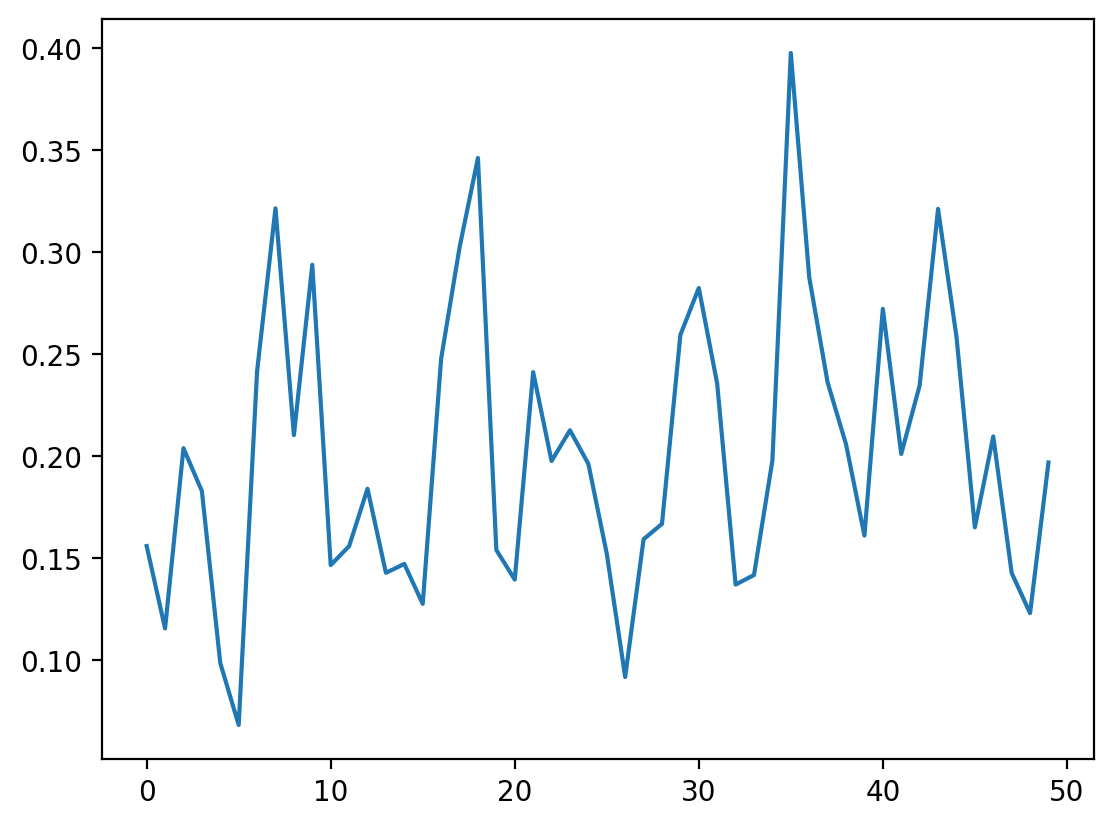

In [122]:
model_with_train.trainloop(trainloader)
plt.plot(model_with_train.loss_during_training)

Visualizing reliability diagram with temperature scaling and ECE results

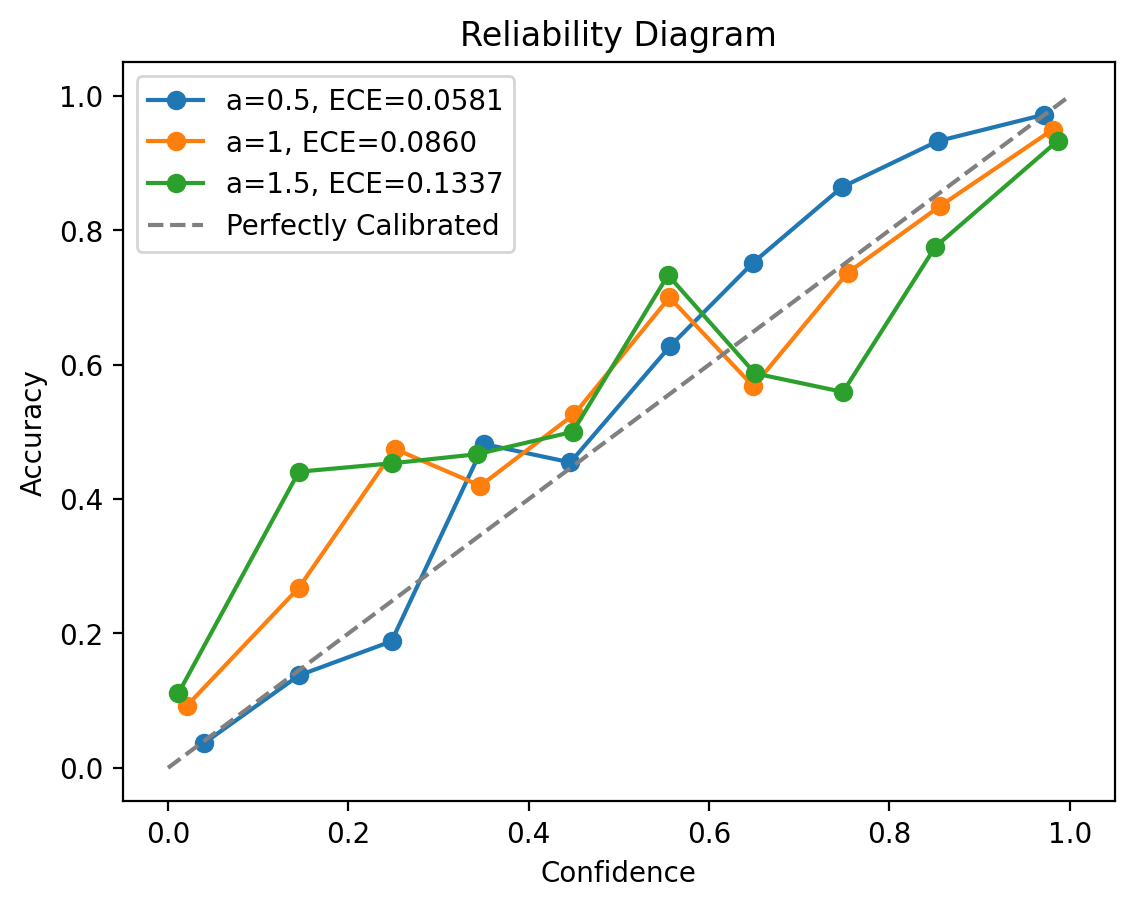

accuracy:  0.8447265625


In [123]:
temperature_parameters = [0.5, 1, 1.5]

for a in temperature_parameters:

    accuracy, confidence, true_labels = model_with_train.eval_performance(testloader, a=a)

    true_labels_binary = [1 if label == 2 else 0 for label in true_labels]

    prob_true, prob_pred = reliability_diagram(confidence, true_labels_binary)
    ece = expected_calibration_error(prob_true, prob_pred)

    plt.plot(prob_pred, prob_true, marker='o', label=f'a={a}, ECE={ece:.4f}')


plt.plot([0, 1], [0, 1], linestyle='--', color='gray', label='Perfectly Calibrated')
x = np.linspace(0, 1, len(prob_pred))

plt.xlabel('Confidence')
plt.ylabel('Accuracy')
plt.title('Reliability Diagram')
plt.legend()
plt.show()
print("accuracy: ", accuracy)